In [660]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as ptch

from datetime import datetime
import time
from os import listdir
from os.path import isfile, join
import re

plt.style.use('fivethirtyeight')
plt.style.use('bmh')

In [651]:
datetime(2020, 3, 15)

datetime.datetime(2020, 3, 15, 0, 0)

# Non-Pharmaceutical Interventions in Canada

Here we show comparisons of descriptive statistics for each regional and subregional-level dataset across Canada. Download individual region CSVs from the Google Sheet and place them in `./data/`. 

Stats Canada data on population size by province available from: 

Statistics Canada. Table 17-10-0009-01 Population estimates, quarterly"
https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710000901
DOI: https://doi.org/10.25318/1710000901-eng


In [647]:
stats_columns=[
    'file',
    'region',
    'subregion', 
    'rows',
    'columns',
    'start_date.min', 
    'start_date.max', 
    'end_date.min', 
    'end_date.max', 
    'end_date.count / count', 
    'reviewer.unique', 
    'intervention_summary.unique', 
    'intervention_category.unique',
    'target_population_category.unique',
    'target_population_category (% not "General")',
    'enforcement_category.unique',
    'oxford_government_response_category.notna',
    'oxford_government_response_category.unique',
    'oxford_fiscal_measure_cad.sum',
    'source_url.unique'
]

columns=[
    'start_date',
    'end_date',
    'reviewer',
    'country',
    'region',
    'subregion',
    'intervention_summary',
    'intervention_category',
    'target_population_category',
    'enforcement_category',
    'oxford_government_response_category',
    'oxford_closure_code',
    'oxford_public_info_code',
    'oxford_travel_code',
    'oxford_geographic_target_code',
    'oxford_fiscal_measure_cad',
    'oxford_monetary_measure',
    'oxford_testing_code',
    'oxford_tracing_code',
    'source_url',
    'source_organization',
    'source_organization_2',
    'source_category',
    'source_title',
    'source_full_text',
    'note'
]

province_files = ['Prince Edward Island.csv', 'Newfoundland and Labrador.csv', 'Alberta.csv', 
             'British Columbia.csv', 'Yukon.csv', 'Saskatchewan.csv',
             'Ontario.csv', 'Nova Scotia.csv', 'New Brunswick.csv',
             'Nunavut.csv', 'Quebec.csv', 'Northwest Territories.csv', 'Manitoba.csv']

In [525]:
population_df = pd.read_csv('statscan-population-q.csv', thousands=',')
population_df[['Geography', 'Q1 2020']]
population_df['region'] = population_df['Geography']
population_df['population_q1_2020'] = pd.to_numeric(population_df['Q1 2020'])
population_df = population_df[['region', 'population_q1_2020']]
population_df

,region,population_q1_2020
0,Canada,37894799
1,Newfoundland and Labrador,521365
2,Prince Edward Island,158158
3,Nova Scotia,977457
4,New Brunswick,779993
5,Quebec,8537674
6,Ontario,14711827
7,Manitoba,1377517
8,Saskatchewan,1181666
9,Alberta,4413146


In [900]:
full_df = pd.read_csv('Collecting NPIs Effects - FULL.csv')
full_df['start_date'] = pd.to_datetime(full_df['start_date'], format='%m/%d/%Y')
full_df['end_date'] = pd.to_datetime(full_df['end_date'], format='%m/%d/%Y')
full_df['oxford_fiscal_measure_cad'] = full_df['oxford_fiscal_measure_cad'].replace('[\$,]', '', regex=True).astype(float)
provinces_df = full_df[full_df['subregion'].isna()]

In [901]:
# TODO: No longer necessary, but would still like the stats.
"""
data_path = './data/'
csvs = [f for f in listdir(data_path) if isfile(join(data_path, f))]
stats_df = pd.DataFrame(columns=stats_columns)

full_df = pd.DataFrame(columns=columns)
provinces_df = pd.DataFrame(columns=columns)

#print(csvs)
for file in csvs:
    if file == ".DS_Store":
        continue
    print('Reading ', file)
    name = file.split("-", 1)[-1].strip(' ')
    df = pd.read_csv(data_path + file)
    df['start_date'] = pd.to_datetime(df['start_date'], format='%m/%d/%Y')
    df['end_date'] = pd.to_datetime(df['end_date'], format='%m/%d/%Y')
    df['oxford_fiscal_measure_cad'] = df['oxford_fiscal_measure_cad'].replace('[\$,]', '', regex=True).astype(float)
    
    full_df = full_df.append(df)
    if name in province_files:
        provinces_df = provinces_df.append(df)
    
    mode_sub = df['subregion'].mode()[0] if len(df['subregion'].mode()) > 0 else ''
    stats = [
        name,
        df['region'].mode()[0],
        mode_sub,
        df.shape[0],
        df.shape[1],
        df['start_date'].min(),
        df['start_date'].max(),
        df['end_date'].min(),
        df['end_date'].max(),
        len(df['end_date'].unique()) / df.shape[0],
        len(df['reviewer'].unique()),
        len(df['intervention_summary'].unique()),
        len(df['intervention_category'].unique()),
        len(df['target_population_category'].unique()),
        df[df['target_population_category'] != 'General'].shape[0] / df.shape[0],
        len(df['enforcement_category'].unique()),
        df[df['oxford_government_response_category'].notna() == True].count().max(),
        len(df['oxford_government_response_category'].unique()),
        df['oxford_fiscal_measure_cad'].sum(), 
        len(df['source_url'].unique()), 
    ]
    file_stats_df = pd.DataFrame([stats], columns=stats_columns)
    stats_df = pd.concat([stats_df, file_stats_df], ignore_index=True)

full_df = full_df.reindex(columns=columns)
provinces_df = provinces_df.reindex(columns=columns)
"""

'\ndata_path = \'./data/\'\ncsvs = [f for f in listdir(data_path) if isfile(join(data_path, f))]\nstats_df = pd.DataFrame(columns=stats_columns)\n\nfull_df = pd.DataFrame(columns=columns)\nprovinces_df = pd.DataFrame(columns=columns)\n\n#print(csvs)\nfor file in csvs:\n    if file == ".DS_Store":\n        continue\n    print(\'Reading \', file)\n    name = file.split("-", 1)[-1].strip(\' \')\n    df = pd.read_csv(data_path + file)\n    df[\'start_date\'] = pd.to_datetime(df[\'start_date\'], format=\'%m/%d/%Y\')\n    df[\'end_date\'] = pd.to_datetime(df[\'end_date\'], format=\'%m/%d/%Y\')\n    df[\'oxford_fiscal_measure_cad\'] = df[\'oxford_fiscal_measure_cad\'].replace(\'[\\$,]\', \'\', regex=True).astype(float)\n    \n    full_df = full_df.append(df)\n    if name in province_files:\n        provinces_df = provinces_df.append(df)\n    \n    mode_sub = df[\'subregion\'].mode()[0] if len(df[\'subregion\'].mode()) > 0 else \'\'\n    stats = [\n        name,\n        df[\'region\'].mode()[

In [902]:
full_df.shape

(1743, 26)

In [903]:
full_df.drop(columns=['reviewer']).to_csv('npi_full.csv')
provinces_df.drop(columns=['reviewer']).to_csv('npi_by_province.csv')

## NPI: Enforcement Categories


In [904]:
len(full_df['enforcement_category'].unique())

6

In [905]:
full_df.groupby(by='enforcement_category').count().max(axis=1).sort_values()



enforcement_category
Arrest                 5
Legal Action          30
Fines                 32
Refusal of Entry     145
Not Applicable      1357
dtype: int64

Text(0.5,0,'count')

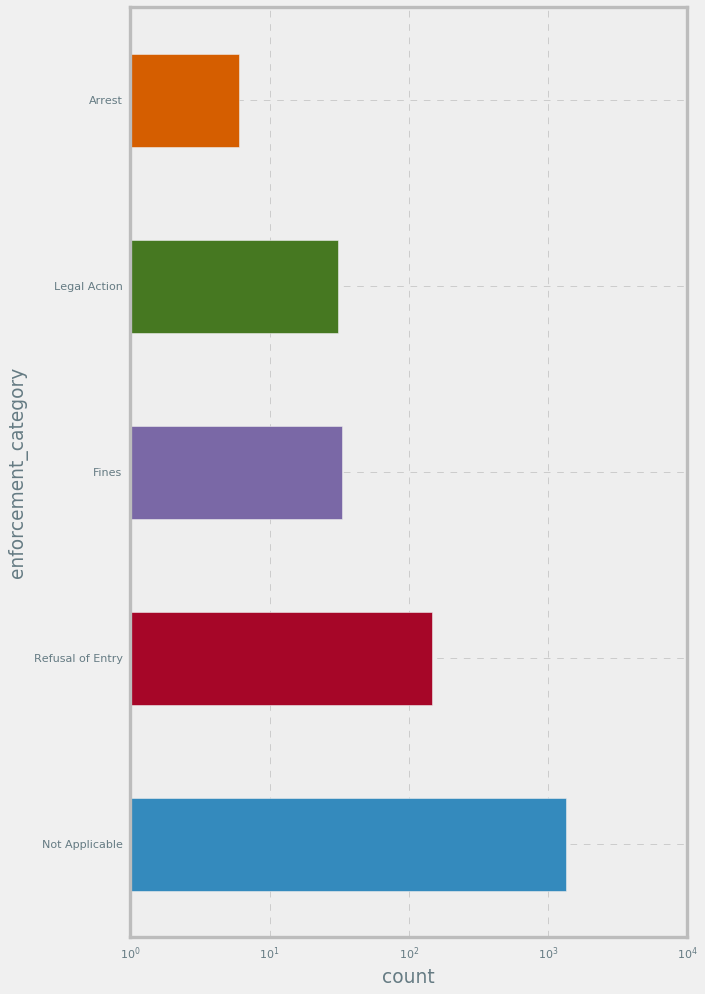

In [913]:
full_df.groupby(by="enforcement_category").count().max(axis=1).sort_values(ascending=False).plot.barh(log=True, figsize=(8,14))
plt.xlabel('count')

In [910]:
len(full_df['target_population_category'].unique())

16

In [911]:
full_df.groupby(by='target_population_category').count().max(axis=1).sort_values()

target_population_category
All Students                             7
Incarcerated Adults                     12
Government Employees                    17
Postsecondary Students                  19
COVID-19 Case Contacts                  23
Adults in Longterm Care Facilities      24
Symptomatic Individuals                 24
Vulnerable Population - Homeless        30
Vulnerable Population - Elderly         31
School Students                         40
Businesses                              55
Vulnerable Populations - Low SES        63
Healthcare Workers                      74
Returning Travellers                    85
General                               1224
dtype: int64

Text(0.5,0,'count')

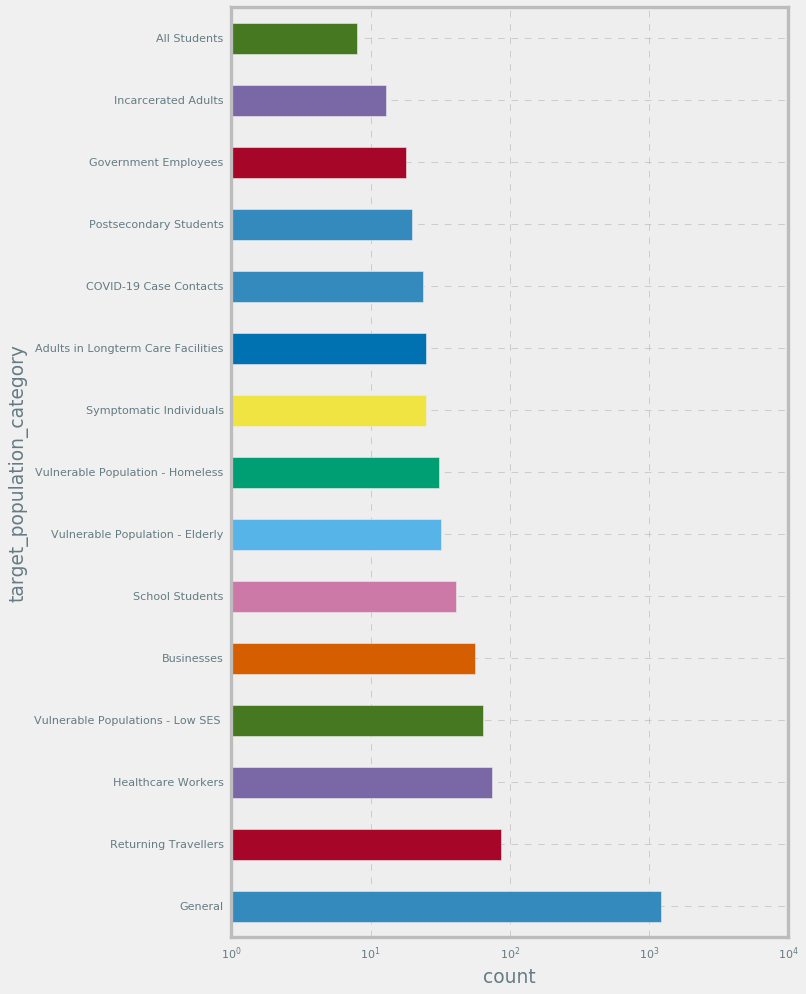

In [912]:
full_df.groupby(by="target_population_category").count().max(axis=1).sort_values(ascending=False).plot.barh(log=True, figsize=(8,14))
plt.xlabel('count')

## NPI: Intervention Categories

In [906]:
len(full_df['intervention_category'].unique())

59

In [907]:
pd.DataFrame(full_df.groupby(by='intervention_category').count().max(axis=1))

,0
intervention_category,
Border closure,5
Case Definition Change,2
Correctional facility restrictions,12
Court closure,19
Creation of command center,16
Declaration of emergency (or similar),49
Education or Work from Home,14
Electoral poll cancelation,6
Emergency economic funding,86


In [908]:
pd.DataFrame(full_df.groupby(by='intervention_category').apply(lambda x: x.sample(1)['intervention_summary'])[0:10])

,,intervention_summary
intervention_category,,
Border closure,1681,Screening measures strengthened at the Confede...
Case Definition Change,1477,Case definition expanded to include travel bey...
Correctional facility restrictions,1384,Outside visitation and non-essential traffic t...
Court closure,760,BC Provincial court reduce operations
Creation of command center,1288,City of Hamilton's Emergery operations Centre ...
Declaration of emergency (or similar),1332,COVID-19 outbreak at long-term care facility
Education or Work from Home,1402,The Department of Education is launching a lea...
Electoral poll cancelation,722,"Defer by-elections in Victoria, Rossland and L..."
Emergency economic funding,1097,Financial measures to support small and medium...


Text(0.5,0,'count')

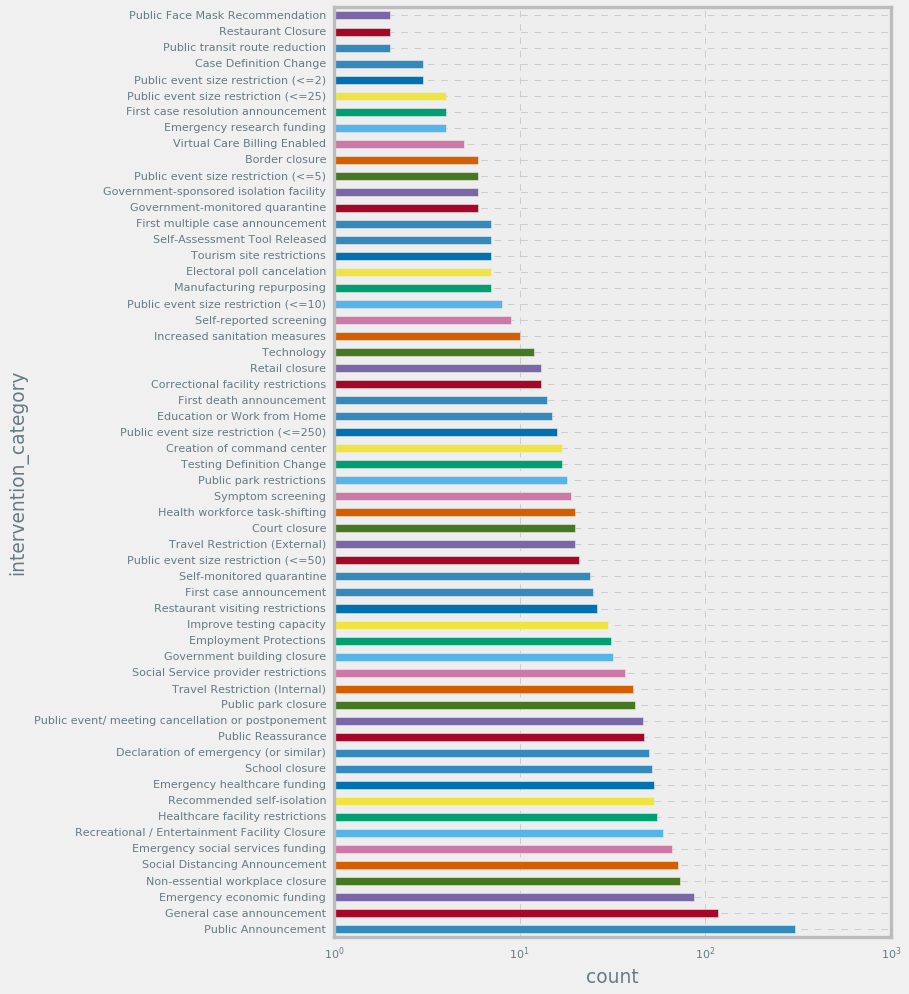

In [909]:

full_df.groupby(by="intervention_category").count().max(axis=1).sort_values(ascending=False).plot.barh(log=True, figsize=(8,14))
plt.xlabel('count')


## NPI: Fiscal Measures

Show investments by province or subregion

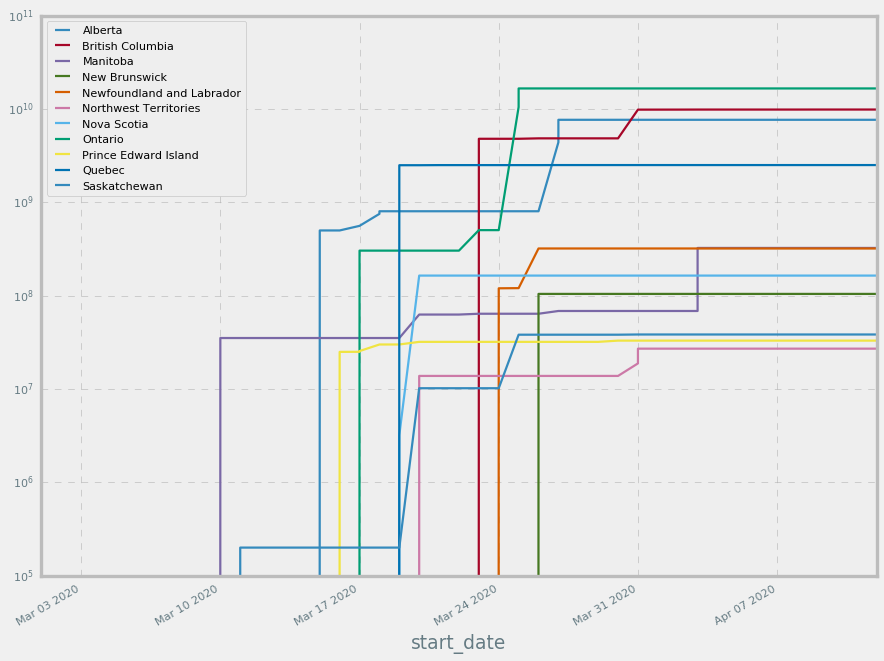

In [566]:
fig, ax = plt.subplots(figsize=(12,10))

dates = pd.date_range(start='03-01-2020', end='04-12-2020', name='dates').to_series() #mm-dd-yyyy
gb = provinces_df[provinces_df['oxford_fiscal_measure_cad'].notna()][['start_date', 'region', 'oxford_fiscal_measure_cad']].groupby(by='region')

for g_name, g_df in gb:
    all_dates_df = g_df.join(dates, on='start_date', how='right')
    all_dates_df['oxford_fiscal_measure_cad'] = all_dates_df['oxford_fiscal_measure_cad'].fillna(0)
    all_dates_df = all_dates_df.sort_values(by='start_date', ascending=True)
    all_dates_df['oxford_fiscal_measure_cad_cumsum'] = all_dates_df['oxford_fiscal_measure_cad'].cumsum(axis=0)
    #print(all_dates_df)
    all_dates_df.plot(x='start_date', y='oxford_fiscal_measure_cad_cumsum', label=g_name, ax=ax)

plt.yscale('log')

In [825]:
provinces_df[provinces_df['oxford_fiscal_measure_cad'].notna()]['oxford_fiscal_measure_cad']

(85,)

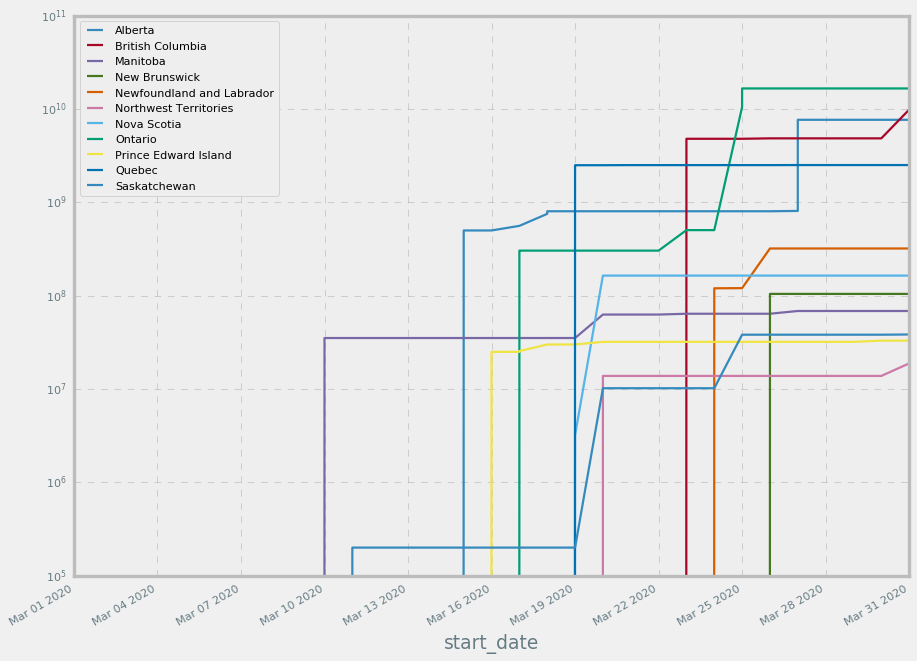

In [832]:
fig, ax = plt.subplots(figsize=(12,10))

dates = pd.date_range(start='03-01-2020', end='03-31-2020', name='dates').to_series() #mm-dd-yyyy
gb = provinces_df[provinces_df['oxford_fiscal_measure_cad'].notna()][['start_date', 'region', 'oxford_fiscal_measure_cad']].groupby(by='region')

for g_name, g_df in gb:
    all_dates_df = g_df.join(dates, on='start_date', how='right')
    all_dates_df['oxford_fiscal_measure_cad'] = all_dates_df['oxford_fiscal_measure_cad'].fillna(0)
    all_dates_df = all_dates_df.sort_values(by='start_date', ascending=True)
    all_dates_df['oxford_fiscal_measure_cad_cumsum'] = all_dates_df['oxford_fiscal_measure_cad'].cumsum(axis=0)
    #print(all_dates_df)
    all_dates_df.plot(x='start_date', y='oxford_fiscal_measure_cad_cumsum', label=g_name, ax=ax)

plt.yscale('log')

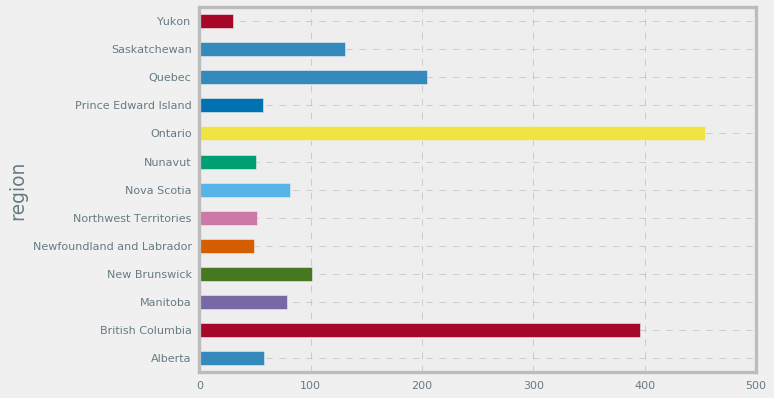

In [915]:
full_df.groupby(by=['region']).count().max(axis=1).plot.barh()

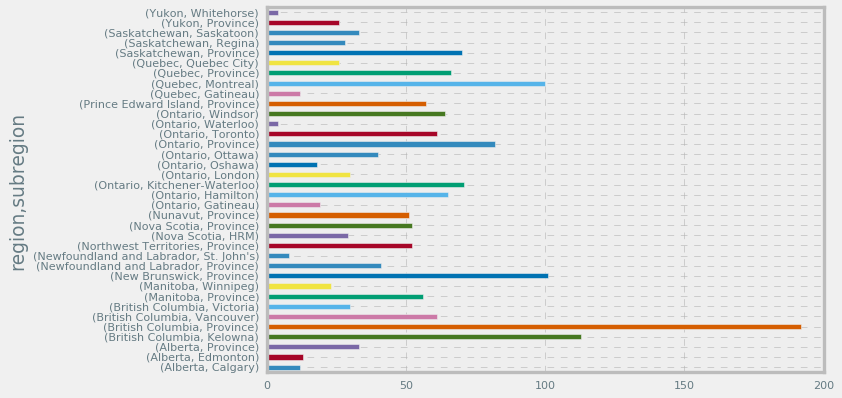

In [919]:
full_df.fillna('Province').groupby(by=['region', 'subregion']).count().max(axis=1).plot.barh()

Text(0.5,0,'Number of unique interventions')

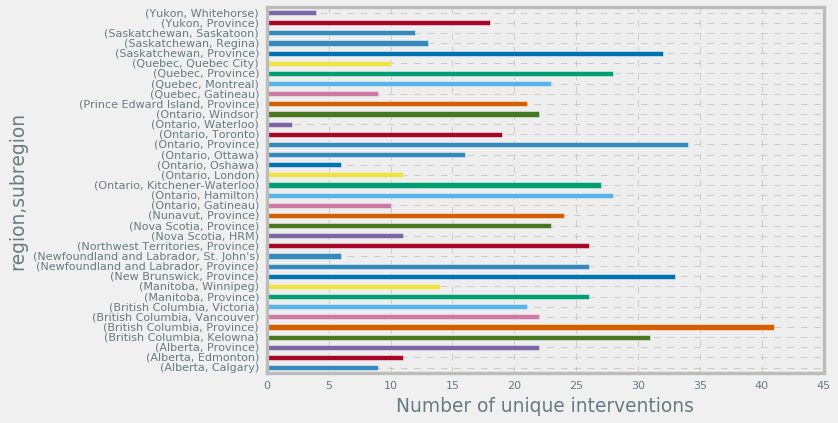

In [921]:
full_df.fillna('Province').groupby(by=['region', 'subregion'])['intervention_category'].nunique().plot.barh()
plt.xlabel('Number of unique interventions recorded')

Text(0.5,0,'Number of unique Oxford interventions recorded')

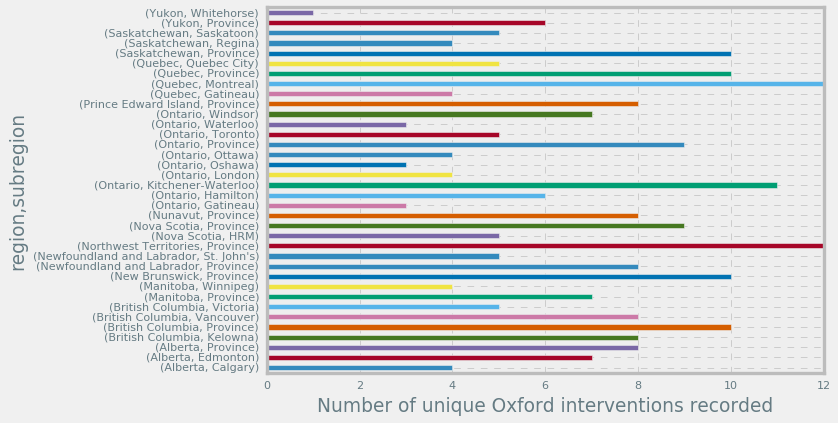

In [922]:
full_df.fillna('Province').groupby(by=['region', 'subregion'])['oxford_government_response_category'].nunique().plot.barh()
plt.xlabel('Number of unique Oxford interventions recorded')


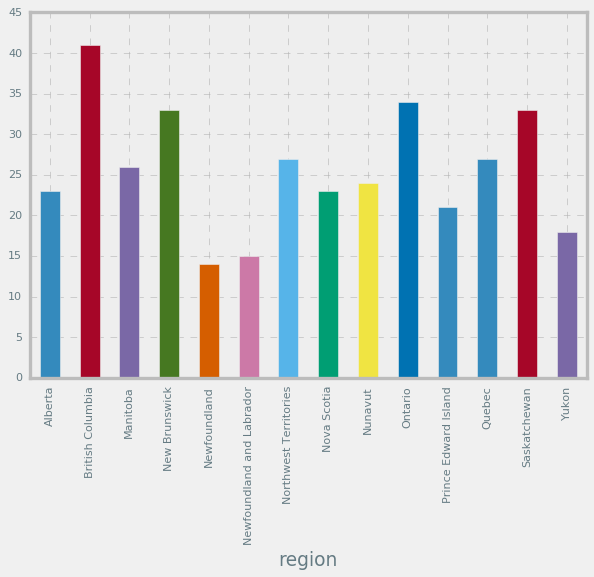

In [786]:
provinces_df.groupby(by='region')['intervention_category'].nunique().plot.bar()

Text(0.5,0,'Number of unique interventions recorded')

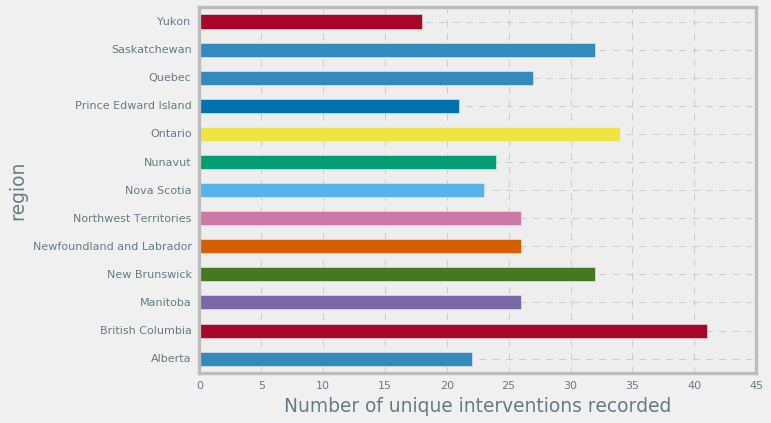

In [923]:
full_df[full_df['subregion'].isna()].groupby(by=['region'])['intervention_category'].nunique().plot.barh()
plt.xlabel('Number of unique interventions recorded')


Text(0.5,0,'Number of unique interventions recorded')

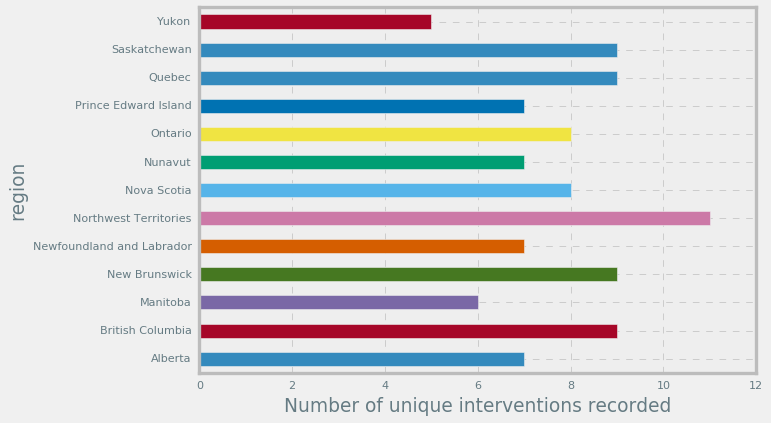

In [924]:
full_df[full_df['subregion'].isna()].groupby(by=['region'])['oxford_government_response_category'].nunique().plot.barh()
plt.xlabel('Number of unique interventions recorded')


Text(0.5,0,'Oxford Fiscal Measure (CAD) recorded')

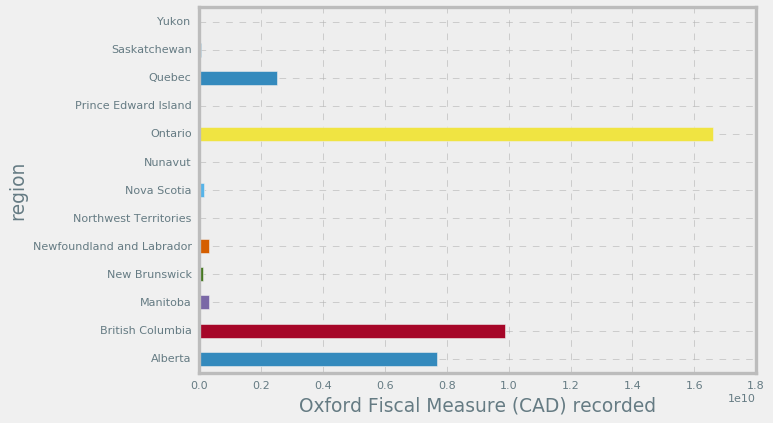

In [925]:
full_df[full_df['subregion'].isna()].groupby(by=['region'])['oxford_fiscal_measure_cad'].sum().plot.barh()
plt.xlabel('Oxford Fiscal Measure (CAD) recorded')


Text(0,0.5,'$ / person')

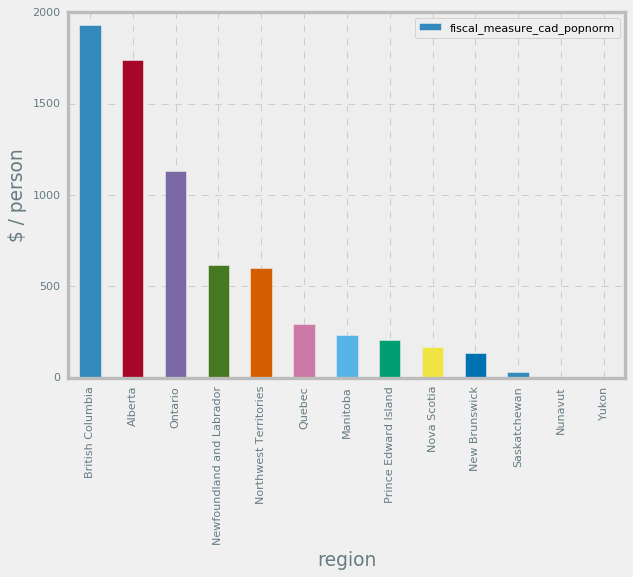

In [858]:
df = pd.DataFrame(provinces_df.groupby(by='region')['oxford_fiscal_measure_cad'].sum())
df['region'] = df.index
df = df.merge(population_df, on='region', how='left')
df['fiscal_measure_cad_popnorm'] = df['oxford_fiscal_measure_cad'] /  df['population_q1_2020']
df = df.sort_values(by='fiscal_measure_cad_popnorm', ascending=False)
df.plot.bar(x='region', y='fiscal_measure_cad_popnorm')
plt.ylabel("$ / person")

Text(0,0.5,'fiscal measures (CAD)')

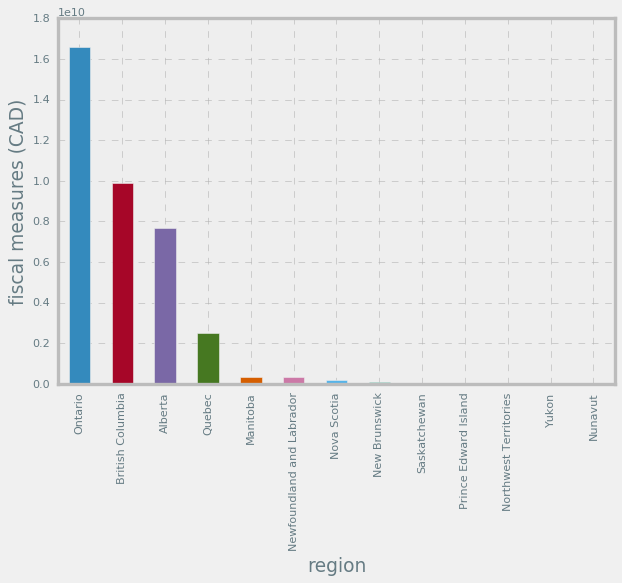

In [859]:
provinces_df.groupby(by='region')['oxford_fiscal_measure_cad'].sum().sort_values(ascending=False).plot.bar()
plt.ylabel('fiscal measures (CAD)')

## Clustering Representation

For now just showing clustering on hand-applied labels.



In [956]:
>>> from sklearn import preprocessing
df = full_df.fillna(-1)

le_re = preprocessing.LabelEncoder()
le_re.fit(df['region'].astype(str).values)
le_ic = preprocessing.LabelEncoder()
le_ic.fit(df['intervention_category'].astype(str).values)
le_ec = preprocessing.LabelEncoder()
le_ec.fit(df['enforcement_category'].astype(str).values)
le_tp = preprocessing.LabelEncoder()
le_tp.fit(df['target_population_category'].astype(str).values)

LabelEncoder()

In [957]:
y = le_ic.transform(df['intervention_category'].astype(str))
X = np.array([
    le_re.transform(df['region'].astype(str)),
    le_ec.transform(df['enforcement_category'].astype(str)),
    le_tp.transform(df['target_population_category'].astype(str)),
    df['oxford_closure_code'].astype(int),
    df['oxford_public_info_code'].astype(int),
    df['oxford_travel_code'].astype(int),
    df['oxford_geographic_target_code'].astype(int)]).T

In [953]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X, y)
X_embedded

array([[ 17.92097  , -32.395767 ],
       [ 17.921694 , -32.395493 ],
       [ 10.063913 ,   8.941804 ],
       ...,
       [ 18.925892 ,   6.8771744],
       [ 28.91071  , -30.945795 ],
       [ 18.925892 ,   6.8771744]], dtype=float32)

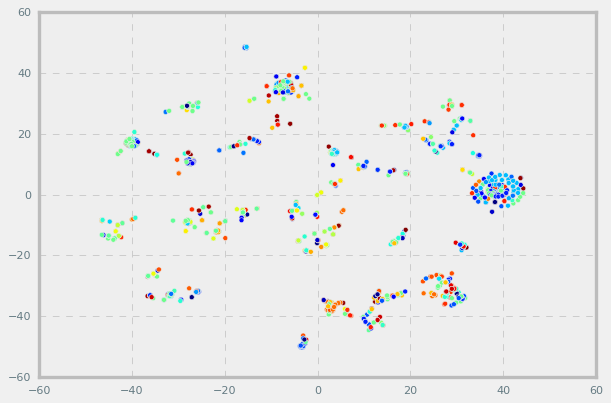

In [959]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y)

## Comparison of Ontario Interventions with Case Data

In [2]:
test_data_path = '../../data/covid19/'
df_c19test_on = pd.read_csv( data_path + 'test_data_on.csv' )

In [5]:
df_npi_on = pd.read_csv( './npi_ontario.csv' )

In [30]:
dates_int_counts = df_npi_on.groupby(by='start_date').count()['intervention_category']

In [43]:
graph_scale=20
ninterventions = df_npi_on.groupby(by='start_date').count()['intervention_category'].values * graph_scale

In [44]:
ndates = list(df_npi_on.groupby(by='start_date').groups.keys())

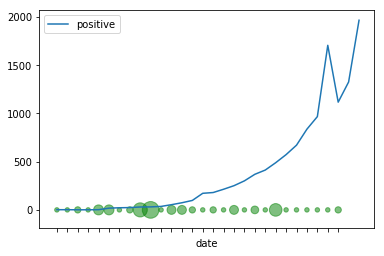

In [48]:
df_c19test_on.plot(x='date', y='positive')
plt.scatter(x=ndates, y=np.zeros(len(ndates)), s=ninterventions, c='g', label='interventions', alpha=0.5)

# LDA on Intervention Text

Topics on full text just find regions. Need to remove all location-based markers from full text.

In [760]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import text 

We choose to leave out geography-related words by marking them as stop words. This seems to prevent the model from picking up on the strong geographical topics in our selection of data and helps it discover other useful clusters.

In [860]:
r = [x.split() for x in full_df['region'].dropna().unique().tolist()]
r = np.hstack([np.array(x) for x in r])
sr = [x.split() for x in full_df['subregion'].dropna().unique().tolist()]
sr = np.hstack([np.array(x) for x in sr])
geo_stop_words = np.append(r, sr)
geo_stop_words = [x.lower() for x in geo_stop_words]
geo_stop_words = [x.replace('(','').replace(')','') for x in geo_stop_words]
stop_words = text.ENGLISH_STOP_WORDS.union(geo_stop_words)

We automate the selection of the number of topics by calculating the perplexity score for the model and minimizing across the number of topics.

In [926]:
def topic_selection(tf, tmax, tstep, debug=False):
    topic_sizes = np.arange(1, tmax, tstep)
    topic_ll = []
    topic_perplexity = []
    models = []
    for k in topic_sizes:


        n_topics = k

        lda = LatentDirichletAllocation(n_components=n_topics, 
            max_iter=10, 
            learning_method='online',
            learning_offset=50.,
            random_state=3).fit(tf)

        # use perplexity for now.. try gensim coherence later
        # see https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/topic_coherence_model_selection.ipynb
        topic_ll.append( lda.score(tf) )
        p = lda.perplexity(tf)
        topic_perplexity.append( p )
        models.append(lda)
        
        if (debug):
            print('Topics: ', k, ' perplexity ', p)
    
    idx = np.where(topic_perplexity == np.amin(topic_perplexity))[0][0]
    selected_lda = models[idx]
    ntopics = topic_sizes[idx]
    return topic_sizes, topic_perplexity, selected_lda, ntopics

In [766]:
def show_topk_words(lda, k, tf_feature_names):
    n_top_words = k
    for topic_i, topic in enumerate(lda.components_):
        print( "Topic ", topic_i )
        print( "Words: ", [tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]] )
        

### Full Source Text

Here we apply LDA to the full text of each source (except french sources)

In [869]:
len(full_df['source_url'].unique()) / full_df.shape[0]

0.5554279149913842

In [819]:
engl_df = full_df[full_df['region'] != 'Quebec']
full_text = engl_df['source_full_text'].drop_duplicates().astype(str)
data = full_text.values
data = [re.sub('\s+', ' ', text) for text in data] # remove new lines
data = [re.sub("\'", "", text) for text in data] # remove quotes
len(data)

860

In [820]:
n_words = 1000
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_words, stop_words=stop_words)
tf = tf_vectorizer.fit_transform( data )
tf_feature_names = tf_vectorizer.get_feature_names()

In [927]:
topic_sizes, topic_perplexity, lda, ntopics = topic_selection(tf, 40, 2)
print("Selected ", ntopics, " topics")

Selected  13  topics


Text(0,0.5,'perplexity')

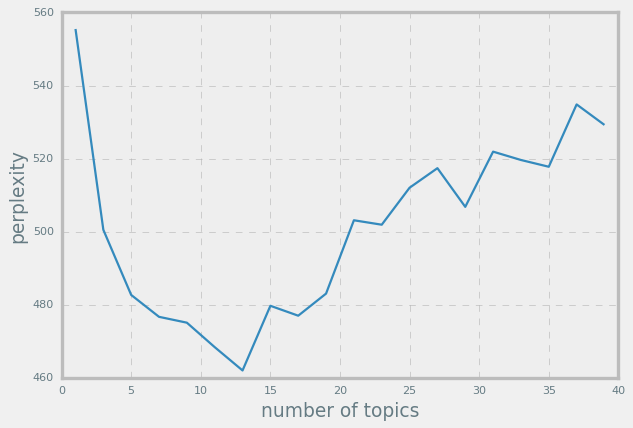

In [862]:
plt.plot(topic_sizes, topic_perplexity)
plt.xlabel('number of topics')
plt.ylabel('perplexity')

In [822]:
show_topk_words(lda, 15, tf_feature_names)

Topic  0
Words:  ['service', 'bus', 'customers', 'march', 'transit', 'halifax', 'games', 'hsr', 'buses', 'use', 'route', 'passengers', 'social', 'distancing', 'closed']
Topic  1
Words:  ['867', 'gov', 'pdf', 'nu', 'gn', 'chief', 'department', 'office', 'gatherings', 'emergency', 'grocery', '975', 'stores', 'events', 'store']
Topic  2
Words:  ['order', 'health', 'public', 'officer', 'act', 'march', '2020', 'section', 'person', 'police', 'request', 'measures', 'orders', 'medical', 'effect']
Topic  3
Words:  ['students', 'school', 'education', 'learning', 'schools', 'parents', 'year', '12', 'communities', 'minister', 'leaders', 'break', 'institutions', 'march', 'nwt']
Topic  4
Words:  ['com', 'residents', 'ca', 'twitter', 'facebook', 'instagram', 'media', 'cityofto', 'information', 'people', '416', 'public', '338', 'economic', 'health']
Topic  5
Words:  ['nwt', 'waste', 'public', 'residents', '19', 'municipal', 'covid', 'collection', 'centre', 'garbage', 'health', 'notice', 'place', 'gnwt

# LDA on Intervention Summary Text

In [591]:
full_summaries = full_df['intervention_summary'].drop_duplicates().astype(str)

In [722]:

n_words = 200

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_words, stop_words='english')
tf = tf_vectorizer.fit_transform( full_summaries )
tf_feature_names = tf_vectorizer.get_feature_names()

Topics:  1
161.6655431885962
Topics:  3
158.8819707894937
Topics:  5
160.2027677133803
Topics:  7
150.99204789508047
Topics:  9
162.65943988464053
Topics:  11
160.22828200412295
Topics:  13
154.98036726891738
Topics:  15
152.8002833678197
Topics:  17
167.88116260735652
Topics:  19
164.78970754154554
Topics:  21
163.74855208606476
Topics:  23
183.4391305930914
Topics:  25
179.03508701177822
Topics:  27
174.4884012679839
Topics:  29
186.72993943882813
Topics:  31
184.26920024260096
Topics:  33
189.77777779035577
Topics:  35
202.4859365939989
Topics:  37
200.80264286558486
Topics:  39
214.22437366162393


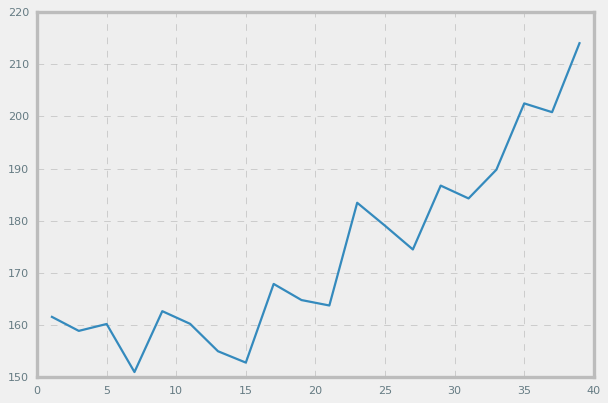

In [723]:
topic_sizes, topic_perplexity, lda, ntopics = topic_selection(tf, 40, 2)
print("Selected ", ntopics, " topics")

In [ ]:
plt.plot(topic_sizes, topic_perplexity)
plt.xlabel('number of topics')
plt.ylabel('perplexity')

In [724]:
show_topk_words(lda, 20, tf_feature_names)

Topic  0
Words:  ['covid', '19', 'health', 'home', 'centre', 'work', 'community', 'employees', 'working', 'assessment', 'patients', 'positive', 'people', 'response', 'information', 'help', 'symptoms', 'testing', 'provide', 'online']
Topic  1
Words:  ['care', 'closure', 'facilities', 'term', 'long', 'centres', 'visitors', 'screening', 'parks', 'parking', 'homes', 'municipal', 'closed', 'park', 'child', 'support', 'hospital', 'close', 'programs', 'hospitals']
Topic  2
Words:  ['emergency', 'provincial', 'people', 'social', 'service', 'distancing', 'gatherings', 'closure', 'guidance', 'state', 'public', '50', 'restaurants', 'businesses', 'measures', 'services', 'delivery', 'declared', 'bars', 'operations']
Topic  3
Words:  ['public', 'health', 'cancelled', 'services', 'contact', 'events', 'transit', 'cancellation', 'use', 'food', 'april', 'capacity', 'investment', 'day', 'stores', 'medical', 'retail', 'cleaning', 'homeless', 'funding']
Topic  4
Words:  ['self', '14', 'days', 'isolate', 't